In [1]:
from joblib import dump, load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score, classification_report, roc_curve, auc, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('../data/PPMI_sncRNAcounts/counts/ML.csv')
sig_transcripts = pd.read_csv('../data/PPMI_sncRNAcounts/counts/sig_transcripts_df_v2.csv')

In [3]:
df = df[['PATNO', 'COHORT'] + sig_transcripts['transcript'].tolist()]

In [4]:
task_names = [('PD', 'prodromal'), ('healthy', 'prodromal'), ('PD', 'healthy')]
tasks = [(1, 4), (2, 4), (1, 2)]

In [5]:
scoring = ['accuracy', 'precision_weighted', 'f1_weighted', 'roc_auc']
data = {}
for name, task in zip(task_names, tasks):
    new_df = df[df['COHORT'].isin(task)]
    X = new_df.drop(['PATNO', 'COHORT'], axis=1)
    y = new_df['COHORT']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    results = cross_validate(model, X_train, y_train, scoring=scoring, cv=10, return_train_score=True, n_jobs=-1, verbose=1)
    data[name] = results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.7s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [6]:
mean_data = {}
for key, value in data.items():
    key = '{} vs. {}'.format(key[0], key[1])
    mean_data[key] = {}
    for k, v in value.items():
        mean_data[key][k] = np.mean(v)
cv_df = pd.DataFrame.from_dict(mean_data)
cv_df.to_csv('../results/sig_cv_results_logistic_regression.csv')

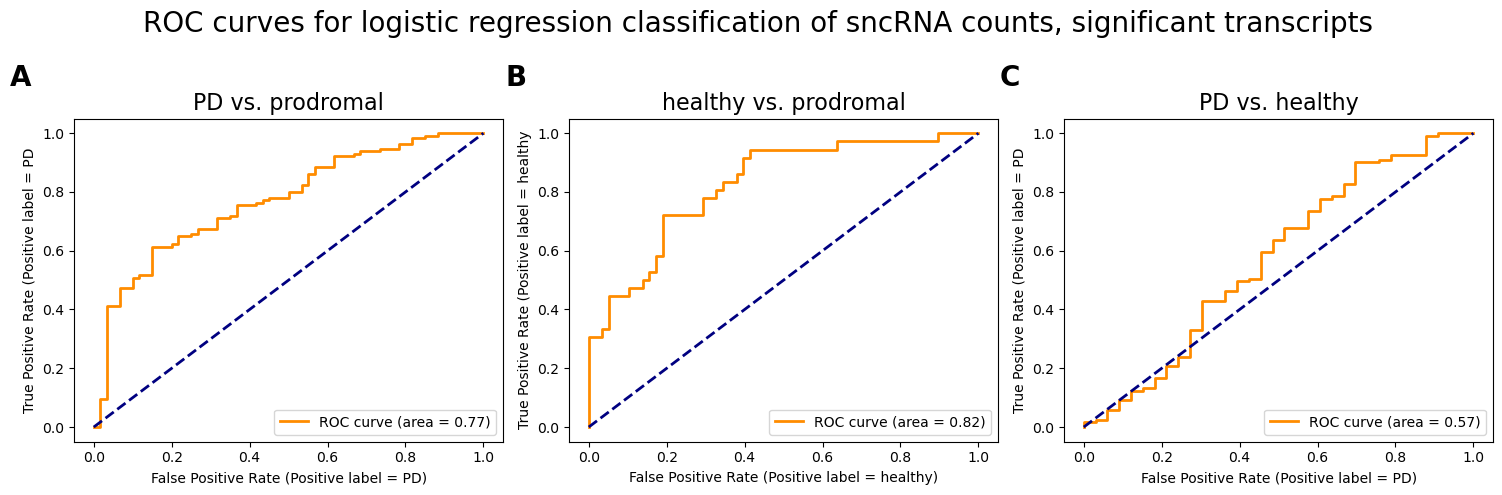

In [7]:
models = {}
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for task, name, ax, letter in zip(tasks, task_names, axes, ['A', 'B', 'C']):
    new_df = df[df['COHORT'].isin(task)]
    X = new_df.drop(['PATNO', 'COHORT'], axis=1)
    y = new_df['COHORT']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_scores[:, 0], pos_label=task[0])
    roc_auc = auc(fpr, tpr)
    temp = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'f1': f1,
        'confusion': confusion,
        'report': report,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }
    models[name] = temp
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel(f'False Positive Rate (Positive label = {name[0]})')
    ax.set_ylabel(f'True Positive Rate (Positive label = {name[0]}')
    ax.set_title('{} vs. {}'.format(*name), fontsize=16)
    ax.legend(loc="lower right")
    ax.text(-0.15, 1.1, letter, transform=ax.transAxes, size=20, weight='bold')
fig.suptitle('ROC curves for logistic regression classification of sncRNA counts, significant transcripts', fontsize=20)
fig.tight_layout()
fig.savefig('../figures/sig_logistic_regression_roc_curves.png', dpi=300)
plt.show()

In [8]:
metrics = pd.DataFrame.from_dict(models, orient='index')
metrics.drop(['model', 'confusion', 'report', 'fpr', 'tpr'], axis=1, inplace=True)
metrics.index = ['{} vs. {}'.format(*name) for name in metrics.index]
metrics.to_csv('../results/sig_metrics_logistic_regression.csv')

In [9]:
for name, model in models.items():
    dump(model, '../models/sig_logistic_regression_{}_{}.joblib'.format(name[0], name[1]))

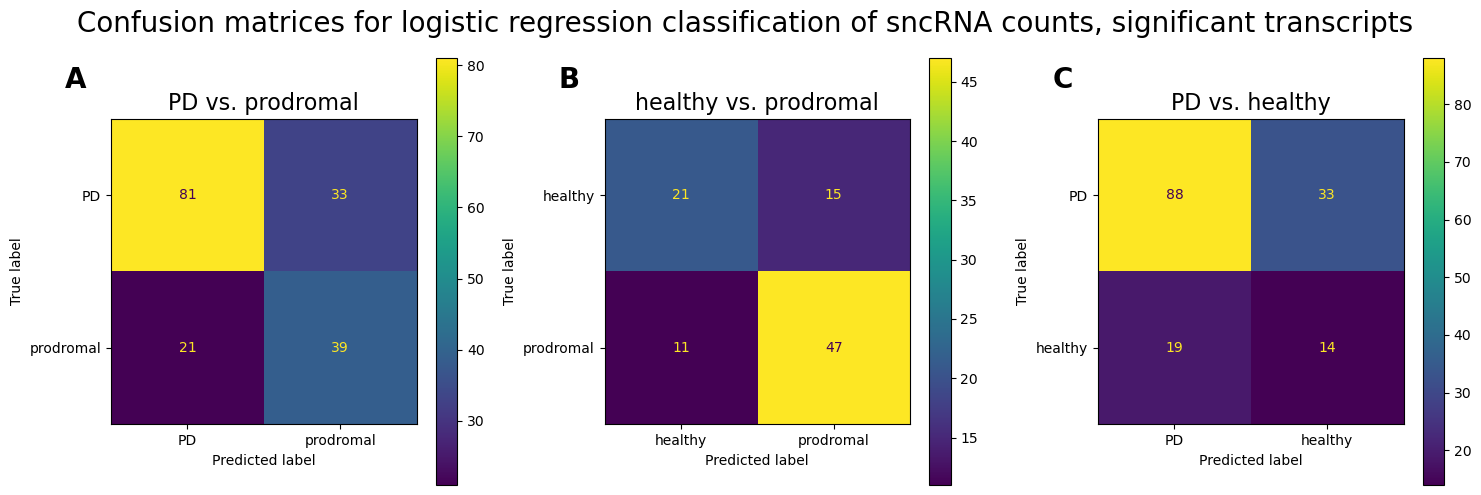

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for (name, model), ax, letter in zip(models.items(), axes, ['A', 'B', 'C']):
    confusion = model['confusion']
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[name[0], name[1]])
    disp.plot(ax=ax)
    ax.set_title('{} vs. {}'.format(*name), fontsize=16)
    ax.text(-0.15, 1.1, letter, transform=ax.transAxes, size=20, weight='bold')
fig.suptitle('Confusion matrices for logistic regression classification of sncRNA counts, significant transcripts', fontsize=20)
fig.tight_layout()
fig.savefig('../figures/sig_logistic_regression_confusion_matrices.png', dpi=300)
plt.show()